

# Svara forms



## Imports

In [1]:
import random
import numpy as np
import pandas as pd
import compiam
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import random
from fastdtw import fastdtw
import sklearn

## 1.Pitch Processing

Carnatic Music constitutes a difficult case for vocal pitch extraction – although performances place strong emphasis on a monophonic melodic line from the soloist singer, heterophonic melodic elements also occur, for example from the accompanying violinist who shadows the melody of the soloist often at a lag and with variation. In addition, there are the sounds of the tanpura (plucked lute that creates an oscillating drone) and pitched percussion instruments.

Here we use a pretrained FTA-Net model for the task. This is provided with the compIAM package via the compiam.load_model() function. The model is an attention-based network that leverages and fuses information from the frequency and periodicity domains to capture the correct pitch values for the predominant source. It learns to focus on this source by using an additional branch that helps reduce the false alarm rate (detecting pitch values that do not correspond to the source we target) 

### 1.1. Predominant Pitch Extraction

First, we need to load the model using `compiam.load_model`.

In [20]:
ftanet_carnatic = compiam.load_model("melody:ftanet-carnatic")

Extracting the vocal pitch track:

In [21]:
ftanet_pitch_track = ftanet_carnatic.predict('/content/drive/MyDrive/raksha_bettare.wav', hop_size=30)

1/1 [==============================] - 6s 6s/step


>FTA-Net inference is computationally expensive, so we can save the pitch track and load it later. This way, we don’t have to estimate the pitch track each time.

In [ ]:
np.save('ftanet_pitch_track.npy', ftanet_pitch_track)

In [95]:
ftanet_pitch_track = np.load('ftanet_pitch_track.npy')

In [96]:
pitch_raw = ftanet_pitch_track[:, 1]
times_raw = ftanet_pitch_track[:, 0]
timestep_raw = times_raw[3] - times_raw[2]

We need to preprocess the data before performing clustering. This includes smoothing, interpolation, and conversion to cents.

First, we will import some utility functions that may be useful.

In [97]:
from src.utils import (
    load_json, load_pitch_track, write_pitch_track, cpath, load_annotations, get_plot_kwargs,
    pitch_seq_to_cents, subsample_series, interpolate_below_length, smooth_pitch_curve,
    align_time_series, write_pkl, expand_zero_regions)

from src.utils import (
    load_json, load_pitch_track, write_pitch_track, cpath, load_annotations, get_plot_kwargs, 
    pitch_seq_to_cents, subsample_series, interpolate_below_length, smooth_pitch_curve,
    align_time_series, write_pkl, load_pkl, remove_leading_trailing_nans, append_row)

from src.pitch import transpose_pitch
from src.clustering import dbscan, silhouette_score, calinski_harabasz_index, davies_bouldin_index, gap_statistic, dbscan_precomp
from src.testing import prec_permutation_test, succ_permutation_test, both_permutation_test

### 1.2.Load metadata and annotations

Now, we will load the metadata for the track we are going to analyze—in this case, *Raksha Bettare*.

In [98]:
metadata_path = 'data/metadata.json'
data = load_json(metadata_path)

Extract the required information from the metadata.

In [99]:
beat_length = data["raksha_bettare"]['beat_length']
tonic = data["raksha_bettare"]['tonic']
annotations_path = f"{data['raksha_bettare']['annotations_path']}"

Now, let's load the annotations.

In [100]:
annotations = load_annotations(annotations_path)
annotations.head()

/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start'] = pd.to_datetime(df['start'])
/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end'] = pd.to_datetime(df['end'])


,start,end,start_sec,end_sec,label
0,2025-04-02 00:00:03.417,2025-04-02 00:00:04.342,3.417,4.342,ri
1,2025-04-02 00:00:04.342,2025-04-02 00:00:04.855,4.342,4.855,ni
2,2025-04-02 00:00:04.855,2025-04-02 00:00:06.041,4.855,6.041,sa
3,2025-04-02 00:00:06.501,2025-04-02 00:00:07.813,6.501,7.813,ri
4,2025-04-02 00:00:07.960,2025-04-02 00:00:09.455,7.960,9.455,ga


Here, we will initialize some parameters for preprocessing the pitch curve.

In [101]:
interp = 100
smoothing_factor = 0.4
subsample = 0.5

### 1.3.Expand Zero Regions

Now, we will expand contiguous zero regions by replacing neighboring values with zeros.

In [102]:
pitch = expand_zero_regions(pitch_raw, round(0.02/timestep_raw))

We don’t need to interpolate at the boundaries, so first, we extract the boundaries from the annotations.

In [103]:
boundaries = np.concatenate([annotations['start_sec'].values, annotations['end_sec'].values])
boundaries_seq = [round(b/timestep_raw) for b in boundaries]

### 1.4.Interpolation

Now, let's interpolate the pitch curve using the provided function `interpolate_below_length`.

In [104]:
pitch = interpolate_below_length(pitch, 0, (interp*0.001/timestep_raw), boundaries_seq)
null_ind = pitch == 0
pitch[pitch<50] = 0
pitch[null_ind] = 0

### 1.5.Convert to cents

We will convert the pitch from frequencies to cents, with the tonic as the reference. For that, we will use `pitch_seq_to_cents`.

In [105]:
pitch = pitch_seq_to_cents(pitch, tonic=tonic)

### 1.6.Smoothing

Now, we will apply smoothing to the pitch curve. First, we will subsample the pitch curve with a proportion of `0.5`. Then, we will use the `smooth_pitch_curve` function to apply smoothing.

In [106]:
# subsample
time, pitch = subsample_series(times_raw, pitch, subsample)

# smoothing
time_beat = time/beat_length
timestep = time_beat[3] - time_beat[2]
pitch = smooth_pitch_curve(time_beat, pitch, smoothing_factor=smoothing_factor)

Now, let's visualize the pitch curve by plotting it.

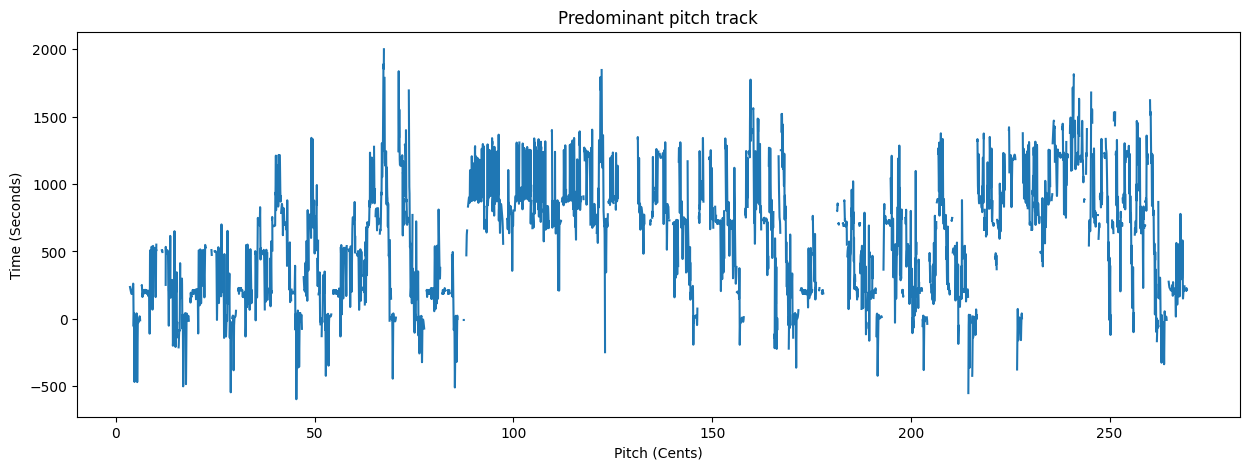

In [107]:
plt.figure(figsize=(15, 5))
plt.title('Predominant pitch track')
plt.xlabel('Pitch (Cents)')
plt.ylabel('Time (Seconds)')
plt.plot(time, pitch)

## 2. Segmentation

Now, we will segment the pitch track using the provided annotations. We will extract each segment and store the corresponding svara from the annotations. For each segment, we will save the svara label and index.

In [108]:
svaras = ['sa', 'ri', 'ga', 'ma', 'pa', 'dha', 'ni']
min_len_prop = 0.6
max_ran = 800
train_size = 0.8
test_size = 0.2

In [109]:
all_svaras = []

for i, row in annotations.iterrows():
    start = row['start_sec']
    end = row['end_sec']
    label = row['label']

    # Skip unknown labels
    if label not in svaras:
        continue
    
    s1_beat = start/beat_length
    s2_beat = end/beat_length
    
    s1 = round(s1_beat/timestep)
    s2 = round(s2_beat/timestep)

    psamp = pitch[s1:s2]
    psamp = remove_leading_trailing_nans(psamp)

    # Skip if there is silence in pitch track    
    if len(psamp) == 0 or len(psamp)/len(pitch[s1:s2]) <= min_len_prop or sum(np.isnan(psamp)>0):
        continue

    psamp, trans = transpose_pitch(psamp)

    ran = max(psamp)-min(psamp)
    
    # exclude incorrectly extracted time series
    if ran > max_ran:
        continue

    all_svaras.append((svaras.index(label), psamp, i, list(data.keys())[1]))

Let's count the number of instances we have for each svara.

In [110]:
counted = Counter([x[0] for x in all_svaras])
for k, v in counted.items():
    print(f"{v} instances of {svaras[k]}")

65 instances of ri
78 instances of ni
57 instances of sa
59 instances of ga
41 instances of ma
62 instances of pa
83 instances of dha


Now, let's balance the count by randomly duplicating the segments for each svara.

In [111]:
n_max = max(counted.values())
for svara in range(len(svaras)):
    these_svaras = [x for x in all_svaras if x[0]==svara]
    if len(these_svaras) == 0:
        continue
    n = len(these_svaras)
    while n < n_max:
        this_svara = random.choice(these_svaras)
        all_svaras.append(this_svara)
        n += 1

In [112]:
counted = Counter([x[0] for x in all_svaras])
for k,v in counted.items():
    print(f"{v} instances of {svaras[k]}")

83 instances of ri
83 instances of ni
83 instances of sa
83 instances of ga
83 instances of ma
83 instances of pa
83 instances of dha


In [113]:
random.shuffle(all_svaras)

## 3.Compute DTW distances

Now, let's perform DTW on each pair of segments. We will create a dictionary with the results.

In [115]:
samp = None
r = 0.3
norm = False

In [116]:
dtw_distances = list()

for i in tqdm.tqdm(list(range(len(all_svaras)))):
    for j in range(len(all_svaras)):
        jl, jpsamp, jannot_ix, jtrack = all_svaras[j]
        il, ipsamp, iannot_ix, itrack = all_svaras[i]

        if jl != il:
            continue

        if il > jl:
            continue

        l_longest = np.max([len(ipsamp), len(jpsamp)])
        radius = round(l_longest*r)
        
        if radius < 2:
            radius = 2

        # Compute DTW distance between ipsamp and jpsamp
        distance, path = fastdtw(ipsamp, jpsamp, dist=lambda x, y: np.linalg.norm(x - y))
        distance = distance/len(path)

        dtw_distances.append({
            'index1': j,
            'index2': i,
            'dtw': distance
        })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 581/581 [03:24<00:00,  2.84it/s]


In [117]:
dtw_distances = pd.DataFrame(dtw_distances)
dtw_distances.head()

,index1,index2,dtw
0,0,0,0.000000
1,3,0,147.916262
2,6,0,90.463277
3,15,0,875.283863
4,18,0,126.089156


## 4.Clustering

The next step is to cluster the pitch curve segments using the DTW distances computed. We will create a 2D NumPy array, with the index representing the segment index. For example, index 5 and 4 will represent the distance between the 5th and 4th segments.

In [118]:
distance_dict = {}
for i, (i1,i2,dist) in dtw_distances.iterrows():
    i1 = int(i1)
    i2 = int(i2)
    if i1 not in distance_dict:
        distance_dict[i1] = {}

    distance_dict[i1][i2] = dist

In [122]:
all_X = np.empty((len(all_svaras), len(all_svaras)))
all_X[:] = np.nan
for i,d in distance_dict.items():
    for j,dist in d.items():
        all_X[i,j] = dist
        all_X[j,i] = dist

In [123]:
from bad import bad

In [124]:
allowed_indices = []
tested = []
for i in range(len(all_svaras)):
    j, psamp, annot_ix, track = all_svaras[i]
    t = f'{track}_{annot_ix}'
    if t not in tested and t not in bad:
        allowed_indices.append(i)
    tested.append(t)

In [125]:
clust_data = {s:{} for s in svaras}
for svara in svaras:

    svara_ix = svaras.index(svara)

    # Get data for this svara
    ix = [i for i,x in enumerate(all_svaras) if x[0]==svara_ix and i in allowed_indices]

    clust_data[svara]['ix'] = ix

We will use the best parameters computed using grid search. 
>For now, we will load the precomputed parameters since grid search is computationally expensive.

In [126]:
kwargs = load_pkl('gridsearch_kwargs.csv')

Now, let's perform clustering using DBSCAN.

In [127]:
print('Clustering...')
clustering = {}
for svara in svaras:
    print(f'    Clustering svara {svara}')

    ix = clust_data[svara]['ix']
    k = kwargs[svara]
    k['cluster_selection_epsilon'] = float(k['cluster_selection_epsilon'])
    k['alpha'] = float(k['alpha'])
    if k['min_samples'] is None or np.isnan(k['min_samples']):
        k['min_samples'] = None
    else:
        k['min_samples'] = int(k['min_samples'])
    print(f'      kwargs: {k}')
    
    ix = clust_data[svara]['ix']

    X = all_X[ix, :][:, ix]
    X = sklearn.preprocessing.normalize(X)

    clus_labels = dbscan_precomp(X, **k)

    print(f'      n_clusters: {max(clus_labels)}')
    clustering[svara] = {'labels':clus_labels, 'ix':ix}

Clustering...
    Clustering svara sa
      kwargs: {'min_samples': 2, 'min_cluster_size': 4, 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.0, 'alpha': 0.8000000000000003}
      n_clusters: 4
    Clustering svara ri
      kwargs: {'min_samples': None, 'min_cluster_size': 2, 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.01, 'alpha': 0.3}
      n_clusters: 6
    Clustering svara ga
      kwargs: {'min_samples': 10, 'min_cluster_size': 2, 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.01, 'alpha': 0.6000000000000001}
      n_clusters: 4
    Clustering svara ma
      kwargs: {'min_samples': 16, 'min_cluster_size': 3, 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.02, 'alpha': 0.4}
      n_clusters: -1
    Clustering svara pa
      kwargs: {'min_samples': 2, 'min_cluster_size': 3, 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.01, 'alpha': 0.5}
      n_clusters: 6
    Clustering svara dha
 

In [128]:
clustering_results = {s:{} for s in svaras}
done = {t:[] for t in data}

for svara in svaras:
    print(f'    Svara {svara}')

    results = clustering[svara]
    
    labels = results['labels']
    all_ix = clust_data[svara]['ix']

    if samp:
        label_tracks = {}
        for track in data:
            label_tracks[track] = [i for i,x in enumerate(labels) if all_svaras[all_ix[i]][3]==track]

        sampled = []
        for track in label_tracks:
            if samp > len(label_tracks[track]):
                sampled += label_tracks[track]
            else:
                sampled += random.sample(label_tracks[track], samp)
    else:
        sampled = list(range(len(labels)))

    no_cluster = []
    for i in tqdm.tqdm(sampled):
        cluster = labels[i]
        ix = all_ix[i]
        _, psamp, annot_ix, track = all_svaras[ix]
        
        if cluster == -1:
            no_cluster += [(annot_ix, track)]
            continue

        if annot_ix in done[track]:
            continue


        row = annotations.iloc[annot_ix]
        start = row['start_sec']
        end = row['end_sec']
        annot_svara = row['label']

        assert annot_svara == svara, 'annotations label does not match svara label'

        clustering_results[svara][ix] = {
            'track': track,
            'annot_ix': annot_ix,
            'cluster': cluster
        }

        done[track].append(annot_ix)

    Svara sa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 20523.73it/s]


    Svara ri


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 29703.37it/s]


    Svara ga


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 54755.93it/s]


    Svara ma


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 466033.78it/s]


    Svara pa


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 34785.48it/s]


    Svara dha


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 22359.19it/s]


    Svara ni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 33036.02it/s]


# Context analysis

In [31]:
context_data = {t: {} for t in data}
print('Extracting Context Information')

for j, psamp, annot_ix, track in tqdm.tqdm(all_svaras):
    if annot_ix in context_data[track]:
        continue

    annotations_path = f"{data[track]['annotations_path']}"
    annotations = load_annotations(annotations_path)

    gap_length = data[track]['beat_length']

    prev_row = annotations.iloc[annot_ix]
    context = {
        'svara': prev_row['label'], 
        'duration': prev_row['end_sec'] - prev_row['start_sec'], 
        'prec': [], 
        'succ': []
    }

    # Append preceding svaras
    for i in range(1, annot_ix + 1):
        this_row = annotations.iloc[annot_ix - i]
        if prev_row['start_sec'] - this_row['end_sec'] > gap_length:
            context['prec'].append('zilence')
            break
        context['prec'].append(this_row['label'])
        prev_row = this_row

    # Append succeeding svaras
    prev_row = annotations.iloc[annot_ix]
    for i in range(1, len(annotations) - annot_ix):
        this_row = annotations.iloc[annot_ix + i]
        if this_row['start_sec'] - prev_row['end_sec'] > gap_length:
            context['succ'].append('zilence')
            break
        context['succ'].append(this_row['label'])
        prev_row = this_row

    # Store context data
    context_data[track][annot_ix] = context

Extracting Context Information


  0%|                                                                                                                                                               | 0/581 [00:00<?, ?it/s]/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start'] = pd.to_datetime(df['start'])
/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end'] = pd.to_datetime(df['end'])
/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please

In [32]:
k = 5

for svara, clusters in clustering_results.items():
    for c in clusters.values():
        track = c['track']
        annot_ix = c['annot_ix']
        context = context_data[track][annot_ix]
        succ_context = context['succ'][:5]
        prec_context = context['prec'][:5]
        prec_context.reverse()
        
        c['prec_context'] = prec_context
        c['succ_context'] = succ_context

unique_clusters = {}
for svara, clusters in clustering_results.items():
    cluster_data = clusters.values()
    for c in set([x['cluster'] for x in cluster_data]):
        this_cluster = [x for x in cluster_data if x['cluster']==c]
        tracks = [x['track'] for x in this_cluster]
        ixs = [x['annot_ix'] for x in this_cluster]
        counted = Counter(tracks)
        contexts = [x['prec_context'] + [f'{svara.upper()}'] + x['succ_context'] for x in this_cluster]
        contexts = [''.join([s[0] for s in c]) for c in contexts]
        cluster_name = f'{svara}_{c}'
        unique_clusters[cluster_name] = {'sequences':[(t,c,i) for t,c,i in zip(contexts, tracks, ixs)]}

In [33]:
K = 5
num_permutations = 10000
results = pd.DataFrame()
for svara in set([x[0] for x in unique_clusters.keys()]):
    print(svara)
    this_unique_clusters = {k:v for k,v in unique_clusters.items() if k[0]==svara}  

    all_groups = [[x[0] for x in tu['sequences']] for tu in this_unique_clusters.values()]
    all_groups = [x for y in all_groups for x in y]

    groups = []
    for group_name, group_d in this_unique_clusters.items():
        #print(group_name)
        this_svara = group_name[0]
        group = [x[0] for x in group_d['sequences']]
        groups.append(group)

    for k in tqdm.tqdm(list(range(1, K+1))):
        print(group)

        prec_res = prec_permutation_test(group, all_groups, k, num_permutations)
        succ_res = succ_permutation_test(group, all_groups, k, num_permutations)
        both_res = both_permutation_test(group, all_groups, k, num_permutations)

        prec_res['svara'] = svara
        succ_res['svara'] = svara
        both_res['svara'] = svara

        results = append_row(results, prec_res)
        results = append_row(results, succ_res)
        results = append_row(results, both_res)

r


  0%|                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

['ppmgrRnsrgm', 'rgrdrRsnddp', 'ndpggRrsndp', 'Rnsz']


 20%|██████████████████████████████▌                                                                                                                          | 1/5 [00:00<00:03,  1.31it/s]

['ppmgrRnsrgm', 'rgrdrRsnddp', 'ndpggRrsndp', 'Rnsz']


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 2/5 [00:01<00:01,  1.61it/s]

['ppmgrRnsrgm', 'rgrdrRsnddp', 'ndpggRrsndp', 'Rnsz']


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3/5 [00:02<00:01,  1.16it/s]

['ppmgrRnsrgm', 'rgrdrRsnddp', 'ndpggRrsndp', 'Rnsz']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4/5 [00:02<00:00,  1.39it/s]

['ppmgrRnsrgm', 'rgrdrRsnddp', 'ndpggRrsndp', 'Rnsz']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


d


  0%|                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

['gmpdpDpmgrp', 'nnndpDndndn', 'dnndpDndnsn']


 20%|██████████████████████████████▌                                                                                                                          | 1/5 [00:00<00:03,  1.27it/s]

['gmpdpDpmgrp', 'nnndpDndndn', 'dnndpDndnsn']


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 2/5 [00:01<00:01,  1.56it/s]

['gmpdpDpmgrp', 'nnndpDndndn', 'dnndpDndnsn']


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3/5 [00:01<00:01,  1.78it/s]

['gmpdpDpmgrp', 'nnndpDndndn', 'dnndpDndnsn']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4/5 [00:02<00:00,  1.87it/s]

['gmpdpDpmgrp', 'nnndpDndndn', 'dnndpDndnsn']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


p


  0%|                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

['dnnddPpdnsg', 'dpsndPndpmg', 'dnsndPmpddn']


 20%|██████████████████████████████▌                                                                                                                          | 1/5 [00:00<00:02,  1.45it/s]

['dnnddPpdnsg', 'dpsndPndpmg', 'dnsndPmpddn']


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 2/5 [00:01<00:01,  1.76it/s]

['dnnddPpdnsg', 'dpsndPndpmg', 'dnsndPmpddn']


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3/5 [00:01<00:01,  1.86it/s]

['dnnddPpdnsg', 'dpsndPndpmg', 'dnsndPmpddn']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4/5 [00:02<00:00,  1.95it/s]

['dnnddPpdnsg', 'dpsndPndpmg', 'dnsndPmpddn']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


g


  0%|                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

['pmdpmGrsdns', 'ddppmGrrnsr']


 20%|██████████████████████████████▌                                                                                                                          | 1/5 [00:00<00:01,  2.86it/s]

['pmdpmGrsdns', 'ddppmGrrnsr']


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 2/5 [00:00<00:01,  2.53it/s]

['pmdpmGrsdns', 'ddppmGrrnsr']


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3/5 [00:01<00:00,  2.42it/s]

['pmdpmGrsdns', 'ddppmGrrnsr']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4/5 [00:01<00:00,  2.33it/s]

['pmdpmGrsdns', 'ddppmGrrnsr']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


n


  0%|                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

['nddpmNdpmdp', 'gmgrsNdpmgr', 'rspgrNdpmpd', 'ndnsnNddppn', 'rgmpdNdnsnd', 'rdrrsNddpmn']


 20%|██████████████████████████████▌                                                                                                                          | 1/5 [00:00<00:03,  1.10it/s]

['nddpmNdpmdp', 'gmgrsNdpmgr', 'rspgrNdpmpd', 'ndnsnNddppn', 'rgmpdNdnsnd', 'rdrrsNddpmn']


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 2/5 [00:01<00:02,  1.09it/s]

['nddpmNdpmdp', 'gmgrsNdpmgr', 'rspgrNdpmpd', 'ndnsnNddppn', 'rgmpdNdnsnd', 'rdrrsNddpmn']


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3/5 [00:02<00:01,  1.30it/s]

['nddpmNdpmdp', 'gmgrsNdpmgr', 'rspgrNdpmpd', 'ndnsnNddppn', 'rgmpdNdnsnd', 'rdrrsNddpmn']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4/5 [00:03<00:00,  1.41it/s]

['nddpmNdpmdp', 'gmgrsNdpmgr', 'rspgrNdpmpd', 'ndnsnNddppn', 'rgmpdNdnsnd', 'rdrrsNddpmn']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]


s


  0%|                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

['rnSz', 'rsgrnSz', 'rsgrnSrgmz', 'rsgrnSrgmgp', 'rsgrnSz', 'pmgrnSggrsg', 'mrgrnSdpdpg', 'rsgrnSz']


 20%|██████████████████████████████▌                                                                                                                          | 1/5 [00:01<00:04,  1.08s/it]

['rnSz', 'rsgrnSz', 'rsgrnSrgmz', 'rsgrnSrgmgp', 'rsgrnSz', 'pmgrnSggrsg', 'mrgrnSdpdpg', 'rsgrnSz']


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 2/5 [00:01<00:02,  1.04it/s]

['rnSz', 'rsgrnSz', 'rsgrnSrgmz', 'rsgrnSrgmgp', 'rsgrnSz', 'pmgrnSggrsg', 'mrgrnSdpdpg', 'rsgrnSz']


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3/5 [00:02<00:01,  1.04it/s]

['rnSz', 'rsgrnSz', 'rsgrnSrgmz', 'rsgrnSrgmgp', 'rsgrnSz', 'pmgrnSggrsg', 'mrgrnSdpdpg', 'rsgrnSz']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4/5 [00:03<00:00,  1.23it/s]

['rnSz', 'rsgrnSz', 'rsgrnSrgmz', 'rsgrnSrgmgp', 'rsgrnSz', 'pmgrnSggrsg', 'mrgrnSdpdpg', 'rsgrnSz']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


In [34]:
results

,real_chi2_stat,real_p_value,real_effect_size,empirical_p_value,mean_random_effect_size,n,svara
0,0.907824,0.969653,0.426104,0.016,0.575787,3.0,r
1,0.690264,0.994699,0.339181,0.112,0.545231,4.0,r
2,1.598997,0.999993,0.326496,0.000,0.544726,4.0,r
3,1.330639,0.999789,0.347803,0.000,0.624443,3.0,r
4,0.849524,0.999919,0.291466,0.000,0.547179,4.0,r
...,...,...,...,...,...,...,...
85,1.449322,1.000000,0.245741,0.000,0.523484,4.0,s
86,NaN,NaN,NaN,NaN,NaN,NaN,s
87,1.404255,1.000000,0.232400,0.000,0.460694,7.0,s
88,1.692308,1.000000,0.245845,0.000,0.626554,3.0,s
